# My capstone project.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

## Data Scraping and creating Dataframe

In [2]:
# Scraping page 1
page = requests.get("https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Pune")
soup = BeautifulSoup(page.content, 'html.parser')
data = soup.find_all("ul")

pune = [li.text for li in data[1].find_all('li')] 
pcmc = [li.text for li in data[2].find_all("li")]

In [3]:
# Scrapping page 2
page2 = pd.read_html("https://en.wikipedia.org/wiki/Peths_in_Pune")[1]

peth = page2['Peth Naam'].tolist()

In [4]:
# Combine data and create dataframe
data = peth + pune + pcmc
df = pd.DataFrame(data)
df.columns= ["Neighbourhood"]
df.head()

,Neighbourhood
0,Kasba Peth
1,Guruwar Peth
2,Somwar Peth
3,Mangalwar Peth
4,Shukrawar Peth


Preprocessing Data

In [5]:
#Rename
df['Neighbourhood'] = df['Neighbourhood'].replace({'Bhamburde (now called Shivajinagar)':'Shivajinagar', 'Ganj Peth(later renamed to Mahatma Phule Peth)': 'Mahatma Phule Peth', 'Manjari': 'Manjari Budruk'})
#df

In [6]:
#Creating new column address with city name as geopy getting wrong locations without city name
df['City'] = 'Pune'
df['address'] = df['Neighbourhood'] +"," + df['City']
df.head()

,Neighbourhood,City,address
0,Kasba Peth,Pune,"Kasba Peth,Pune"
1,Guruwar Peth,Pune,"Guruwar Peth,Pune"
2,Somwar Peth,Pune,"Somwar Peth,Pune"
3,Mangalwar Peth,Pune,"Mangalwar Peth,Pune"
4,Shukrawar Peth,Pune,"Shukrawar Peth,Pune"


From geopy finding coordinates in  Lat, Long

In [7]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="capstone")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
df['location'] = df['address'].apply(geocode)

In [8]:
df['Latitude'] = df['location'] .apply(lambda loc: loc.latitude if loc else None)
df['Longitude'] = df['location'].apply(lambda loc: loc.longitude if loc else None)

In [9]:
pune_data = df.drop(['location', 'address'], axis=1)

#Droping location with no cords
pune_data.dropna(axis=0, inplace=True)

# droping 2 locations as too far from the city
pune_data= pune_data.set_index('Neighbourhood')
pune_data.drop(['Ambegaon', 'Vitthalwadi','Mohammed Wadi'], axis=0, inplace=True)
pune_data = pune_data.reset_index()

pune_data.head()

,Neighbourhood,City,Latitude,Longitude
0,Kasba Peth,Pune,18.521905,73.858290
1,Guruwar Peth,Pune,18.511359,73.857620
2,Somwar Peth,Pune,18.528877,73.874415
3,Mangalwar Peth,Pune,18.524339,73.859208
4,Shukrawar Peth,Pune,18.511354,73.854011


### Save to csv file for further use as geopy takes too much time to load

In [10]:
#df.to_csv(r'pune_data.csv', index=False, header=True)

In [11]:
pune_data = pd.read_csv('trial.csv')

## Creating map of Pune & adding locations

In [12]:
import folium
import json

In [13]:
address ='Pune'
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='Pune')
location =geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Cords of Pune : {}, {}.".format(latitude, longitude))

Cords of Pune : 18.521428, 73.8544541.


In [14]:
import folium
map_pune = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng,Neighbourhood in zip(pune_data['Latitude'], pune_data['Longitude'], pune_data['Neighbourhood']):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pune)  
    
map_pune

## Using forsquere API 

In [15]:
# My credentials
with open('credentials.json')as f:
    data= json.load(f)
for key,val in data.items():
    exec(key + '=val')


In [16]:
radius=500
LIMIT=100

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
pune_venues = getNearbyVenues(names=pune_data['Neighbourhood'],
                                   latitudes=pune_data['Latitude'],
                                   longitudes=pune_data['Longitude']
                                  )

Kasba Peth
Guruwar Peth
Somwar Peth
Mangalwar Peth
Shukrawar Peth
Shaniwar Peth
Bhavani Peth
Ghorpade Peth
Budhwar Peth
Ganesh Peth
Sadashiv Peth
Narayan Peth
Rasta Peth
Nana Peth
Mahatma Phule Peth
Navi Peth
Aundh
Baner
Bavdhan Khurd
Bavdhan Budruk
Balewadi
Shivajinagar
Bibvewadi
Bhugaon
Bhukum
Dhanori
Dhayari
Fursungi
Ghorpadi
Hadapsar
Hingne Khurd
Karve Nagar
Katraj
Khadki
Kharadi
Kondhwa
Koregaon Park
Kothrud
Mundhwa
Nanded
Parvati
Pashan
Pirangut
Shivane
Sus
Undri
Vishrantwadi
Vadgaon Budruk
Wadgaon Sheri
Wagholi
Wanowrie
Warje
Yerwada
Akurdi
Bhosari
Chakan
Chikhli
Chinchwad
Dapodi
Dehu Road
Hinjawadi
Kalewadi
Kasarwadi
Maan
Moshi
Phugewadi
Pimple Gurav
Pimple Nilakh
Pimple Saudagar
Pimpri
Ravet
Rahatani
Sangvi
Talawade
Tathawade
Thergaon
Wakad


In [19]:
pune_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kasba Peth,18.521905,73.85829,Lal Mahal,18.518720,73.856556,Historic Site
1,Kasba Peth,18.521905,73.85829,Shaniwar Wada,18.520151,73.855187,Historic Site
2,Guruwar Peth,18.511359,73.85762,Raja Dinkar Kelkar museum,18.510744,73.854389,History Museum
3,Guruwar Peth,18.511359,73.85762,Shrikrishna Bhuvan,18.513494,73.855074,Snack Place
4,Guruwar Peth,18.511359,73.85762,Shree Wadeshwar Bhuvan,18.510753,73.853748,Vegetarian / Vegan Restaurant


In [20]:
pune_venues.shape

(487, 7)

In [21]:
#Group by Neighborhood
pune_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Akurdi,15,15,15,15,15,15
Aundh,32,32,32,32,32,32
Balewadi,1,1,1,1,1,1
Baner,13,13,13,13,13,13
Bavdhan Budruk,3,3,3,3,3,3
...,...,...,...,...,...,...
Wadgaon Sheri,3,3,3,3,3,3
Wagholi,3,3,3,3,3,3
Wakad,4,4,4,4,4,4


### One Hot Encoding

In [22]:
pune_onehot = pd.get_dummies(pune_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
pune_onehot['Neighbourhood'] = pune_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [pune_onehot.columns[-1]] + list(pune_onehot.columns[:-1])
pune_onehot.head()

,ATM,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Badminton Court,Bakery,Bar,Bookstore,...,Tea Room,Thai Restaurant,Theater,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store,Zoo,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kasba Peth
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kasba Peth
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Guruwar Peth
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Guruwar Peth
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Guruwar Peth


In [23]:
# Group rows by neighborhood according to their mean

pune_grouped = pune_onehot.groupby('Neighbourhood').mean().reset_index()
pune_grouped

,Neighbourhood,ATM,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Badminton Court,Bakery,Bar,...,Sporting Goods Shop,Tea Room,Thai Restaurant,Theater,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store,Zoo
0,Akurdi,0.000000,0.000000,0.0,0.00000,0.066667,0.0,0.0,0.066667,0.0,...,0.0000,0.066667,0.0,0.0,0.0,0.066667,0.0,0.00000,0.0,0.0
1,Aundh,0.000000,0.000000,0.0,0.03125,0.000000,0.0,0.0,0.000000,0.0,...,0.0625,0.000000,0.0,0.0,0.0,0.000000,0.0,0.03125,0.0,0.0
2,Balewadi,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
3,Baner,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
4,Bavdhan Budruk,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Wadgaon Sheri,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
65,Wagholi,0.333333,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
66,Wakad,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
67,Wanowrie,0.000000,0.052632,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0


Print each neighborhood along with the top 5 most common venues

In [24]:
num_top_venues = 5

for hood in pune_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = pune_grouped[pune_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akurdi----
                       venue  freq
0          Indian Restaurant  0.13
1                       Café  0.13
2       Fast Food Restaurant  0.13
3  Middle Eastern Restaurant  0.07
4                  Juice Bar  0.07


----Aundh----
                  venue  freq
0     Indian Restaurant  0.12
1  Fast Food Restaurant  0.06
2   Sporting Goods Shop  0.06
3         Shopping Mall  0.06
4           Snack Place  0.06


----Balewadi----
                venue  freq
0         IT Services   1.0
1  Miscellaneous Shop   0.0
2         Pizza Place   0.0
3                Park   0.0
4     Organic Grocery   0.0


----Baner----
                  venue  freq
0     Indian Restaurant  0.31
1  Fast Food Restaurant  0.15
2                  Café  0.08
3         Grocery Store  0.08
4        Ice Cream Shop  0.08


----Bavdhan Budruk----
                  venue  freq
0     Indian Restaurant  0.33
1  Fast Food Restaurant  0.33
2                  Lake  0.33
3    Miscellaneous Shop  0.00
4                  Pa

top 10 venues to Dataframe

In [25]:
# Sort Decending
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = pune_grouped['Neighbourhood']

for ind in np.arange(pune_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pune_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akurdi,Indian Restaurant,Fast Food Restaurant,Café,Train,Asian Restaurant,Tea Room,Bakery,Platform,Snack Place,Middle Eastern Restaurant
1,Aundh,Indian Restaurant,Fast Food Restaurant,Sporting Goods Shop,Snack Place,Shopping Mall,Breakfast Spot,Korean Restaurant,Plaza,Coffee Shop,Clothing Store
2,Balewadi,IT Services,Garden,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Food Truck
3,Baner,Indian Restaurant,Fast Food Restaurant,Café,Ice Cream Shop,Health & Beauty Service,Convenience Store,Grocery Store,Motorcycle Shop,Snack Place,Zoo
4,Bavdhan Budruk,Indian Restaurant,Fast Food Restaurant,Lake,Zoo,Garden,Falafel Restaurant,Farmers Market,Flea Market,Food,Food Court


## Make Clusters of Neighborhoods

In [27]:
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans


Bad key "text.kerning_factor" on line 4 in
C:\Users\Apurv\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [28]:
x = pune_grouped.drop('Neighbourhood', 1)

### Finding optimal value of K

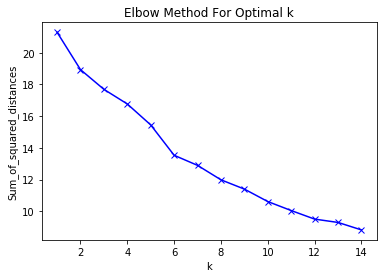

In [29]:
#Method 1 Elbow Method

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=5)
    km = km.fit(x)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Elbow is at 3 and 4 but not clear hance we try one more method

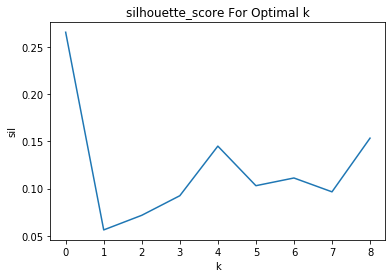

In [30]:
#Method 2 : silhouette score

from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k, random_state=5).fit(x)
  labels = kmeans.labels_
  sil.append(silhouette_score(x, labels, metric = 'euclidean'))

plt.plot(sil)
plt.xlabel('k')
plt.ylabel('sil')
plt.title('silhouette_score For Optimal k')
plt.show()

Higest peak at 4, so selecting K = 4

### Creating k-means to cluster the neighborhood into 3 clusters.

In [31]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(x)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 2, 2, 1, 1, 3, 3, 2, 0, 2, 3, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 3, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 3, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2])

Creating new Dataframe

In [32]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

pune_merged = pune_data

# merge pune_grouped with pune_data to add latitude/longitude for each neighborhood
pune_merged = pune_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

pune_merged.head() # check the last columns!

,Neighbourhood,City,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kasba Peth,Pune,18.521905,73.858290,3.0,Historic Site,Zoo,Garden,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court
1,Guruwar Peth,Pune,18.511359,73.857620,2.0,Vegetarian / Vegan Restaurant,Dessert Shop,History Museum,Fruit & Vegetable Store,Ice Cream Shop,Indian Restaurant,Flea Market,Jewelry Store,Mobile Phone Shop,Snack Place
2,Somwar Peth,Pune,18.528877,73.874415,2.0,Hotel,Platform,Movie Theater,Indian Restaurant,Clothing Store,Fast Food Restaurant,Gastropub,Seafood Restaurant,Lounge,Dessert Shop
3,Mangalwar Peth,Pune,18.524339,73.859208,2.0,Coffee Shop,Zoo,Garden,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Food Truck
4,Shukrawar Peth,Pune,18.511354,73.854011,2.0,Dessert Shop,Vegetarian / Vegan Restaurant,Men's Store,Ice Cream Shop,Indian Restaurant,Jewelry Store,Miscellaneous Shop,Breakfast Spot,Snack Place,Road


In [33]:
#Drop NA
pune_merged=pune_merged.dropna()

In [34]:
#Convert cluster values to int
pune_merged['Cluster_Labels'] = pune_merged.Cluster_Labels.astype(int)

## Create map of clusters

In [35]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pune_merged['Latitude'], pune_merged['Longitude'], pune_merged['Neighbourhood'], pune_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [36]:
pune_merged.loc[pune_merged['Cluster_Labels'] == 0, pune_merged.columns[[0] + list(range(5, pune_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Bhukum,ATM,Garden,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Food Truck
25,Dhanori,ATM,Chinese Restaurant,Garden,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Food Truck
67,Pimple Nilakh,ATM,Garden,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Food Truck
71,Rahatani,ATM,Breakfast Spot,Gastropub,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Food Truck


In [37]:
pune_merged.loc[pune_merged['Cluster_Labels'] == 1, pune_merged.columns[[0] + list(range(5, pune_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Ganesh Peth,Indian Restaurant,Fast Food Restaurant,Restaurant,Movie Theater,Zoo,Furniture / Home Store,Falafel Restaurant,Farmers Market,Flea Market,Food
15,Navi Peth,Indian Restaurant,Snack Place,Coffee Shop,River,Breakfast Spot,Zoo,Furniture / Home Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant
17,Baner,Indian Restaurant,Fast Food Restaurant,Café,Ice Cream Shop,Health & Beauty Service,Convenience Store,Grocery Store,Motorcycle Shop,Snack Place,Zoo
19,Bavdhan Budruk,Indian Restaurant,Fast Food Restaurant,Lake,Zoo,Garden,Falafel Restaurant,Farmers Market,Flea Market,Food,Food Court
31,Karve Nagar,Indian Restaurant,Fast Food Restaurant,Gym,Snack Place,Diner,Zoo,Furniture / Home Store,Electronics Store,Falafel Restaurant,Farmers Market
34,Kharadi,Indian Restaurant,Fast Food Restaurant,South Indian Restaurant,Zoo,Garden,Electronics Store,Falafel Restaurant,Farmers Market,Flea Market,Food
37,Kothrud,Indian Restaurant,Dessert Shop,Snack Place,Café,Historic Site,Fast Food Restaurant,Gym,Restaurant,Men's Store,Falafel Restaurant
41,Pashan,Indian Restaurant,Farmers Market,Flea Market,Zoo,Gastropub,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck
43,Shivane,ATM,Indian Restaurant,Gastropub,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Food Truck
44,Sus,Indian Restaurant,Café,Zoo,Garden,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court


In [38]:
pune_merged.loc[pune_merged['Cluster_Labels'] == 2, pune_merged.columns[[0] + list(range(5, pune_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Guruwar Peth,Vegetarian / Vegan Restaurant,Dessert Shop,History Museum,Fruit & Vegetable Store,Ice Cream Shop,Indian Restaurant,Flea Market,Jewelry Store,Mobile Phone Shop,Snack Place
2,Somwar Peth,Hotel,Platform,Movie Theater,Indian Restaurant,Clothing Store,Fast Food Restaurant,Gastropub,Seafood Restaurant,Lounge,Dessert Shop
3,Mangalwar Peth,Coffee Shop,Zoo,Garden,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Food Truck
4,Shukrawar Peth,Dessert Shop,Vegetarian / Vegan Restaurant,Men's Store,Ice Cream Shop,Indian Restaurant,Jewelry Store,Miscellaneous Shop,Breakfast Spot,Snack Place,Road
7,Ghorpade Peth,Coffee Shop,Zoo,Garden,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Food Truck
10,Sadashiv Peth,Indian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Dessert Shop,Ice Cream Shop,Snack Place,Breakfast Spot,Restaurant,Convenience Store,Diner
11,Narayan Peth,Indian Restaurant,Ice Cream Shop,Dessert Shop,Men's Store,Jewelry Store,Snack Place,Miscellaneous Shop,Plaza,Restaurant,Road
12,Rasta Peth,Seafood Restaurant,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Snack Place,Sandwich Place,Zoo,Electronics Store,Falafel Restaurant,Farmers Market
14,Mahatma Phule Peth,Snack Place,Indian Restaurant,Restaurant,Food Truck,Diner,Zoo,Furniture / Home Store,Electronics Store,Falafel Restaurant,Farmers Market
16,Aundh,Indian Restaurant,Fast Food Restaurant,Sporting Goods Shop,Snack Place,Shopping Mall,Breakfast Spot,Korean Restaurant,Plaza,Coffee Shop,Clothing Store


In [39]:
pune_merged.loc[pune_merged['Cluster_Labels'] == 3, pune_merged.columns[[0] + list(range(5, pune_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kasba Peth,Historic Site,Zoo,Garden,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court
5,Shaniwar Peth,Historic Site,Bakery,Motorcycle Shop,Arts & Crafts Store,Seafood Restaurant,Indian Restaurant,Tea Room,Plaza,Gym,Food Court
6,Bhavani Peth,Historic Site,Multiplex,Bakery,Gym,Motorcycle Shop,Zoo,Fruit & Vegetable Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant
8,Budhwar Peth,Historic Site,Ice Cream Shop,Arts & Crafts Store,Neighborhood,Bakery,Flea Market,Zoo,Garden,Farmers Market,Fast Food Restaurant
13,Nana Peth,Historic Site,Ice Cream Shop,Indian Restaurant,Arts & Crafts Store,Bakery,Gym,Zoo,Garden,Farmers Market,Fast Food Restaurant
54,Bhosari,IT Services,Flea Market,Garden,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food Court,Food Truck


***
***
### Based on above analysis we can define this clusters as below

Cluster 1 : Village Places

Cluster 2 : Traditional places

Cluster 3 : Modern places

Cluster 4 : Public places
***
***

### -End of Project